# Space and time MOC

In [1]:
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.coordinates import Angle, SkyCoord
from astropy.table import Table
from astropy.time import Time, TimeDelta
from mocpy import MOC, STMOC, WCS, TimeMOC

In [2]:
# Load 2MASS data
data = Table.read("./../resources/STMOC/2MASS-list-images.fits.gz", format="fits")

times_start = Time(data["mjd"].data, format="mjd", scale="tdb")
times_end = times_start + TimeDelta(1800, scale="tdb", format="sec")

positions = SkyCoord(data["ra"].quantity, data["dec"].quantity)

In [3]:
%%time
# Create a cone footprint from the first 10000 observations
num_observations = 10000
spatial_coverages = [
    MOC.from_cone(pos.ra, pos.dec, radius=5 * u.deg, max_depth=7)
    for pos in positions[:num_observations]
]
print("Number of rows in 2MASS: ", len(spatial_coverages))  # noqa: T201
# Create a STMOC from those 10000 spatial coverages associated with their observational time ranges
stmoc = STMOC.from_spatial_coverages(
    times_start[:num_observations],
    times_end[:num_observations],
    spatial_coverages,
)

Number of rows in 2MASS:  10000
CPU times: user 4.01 s, sys: 56.5 ms, total: 4.07 s
Wall time: 4.04 s


In [4]:
tmoc = TimeMOC.from_time_ranges(
    min_times=Time(["1998-01-01"], format="iso", scale="tdb"),
    max_times=Time(["1999-01-01"], format="iso", scale="tdb"),
    delta_t=TimeDelta(1e-6, scale="tdb", format="sec"),
)
moc = stmoc.query_by_time(tmoc)

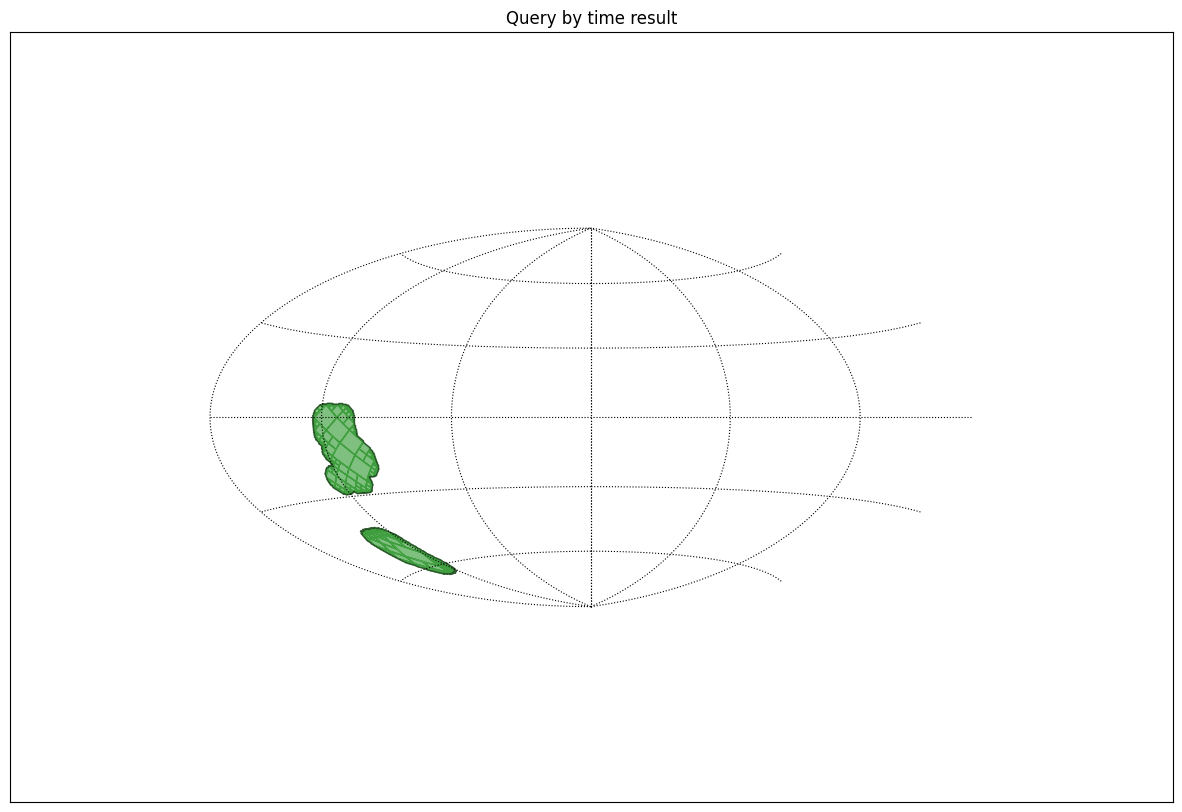

In [5]:
fig = plt.figure(111, figsize=(15, 10))
# Define a astropy WCS easily
with WCS(
    fig,
    fov=330 * u.deg,
    center=SkyCoord(0, 0, unit="deg", frame="icrs"),
    coordsys="icrs",
    rotation=Angle(0, u.degree),
    projection="AIT",
) as wcs:
    ax = fig.add_subplot(1, 1, 1, projection=wcs)
    # Call fill with a matplotlib axe and the `~astropy.wcs.WCS` wcs object.
    moc.fill(ax=ax, wcs=wcs, alpha=0.5, fill=True, color="green")
    moc.border(ax=ax, wcs=wcs, alpha=0.5, color="black")
plt.xlabel("ra")
plt.ylabel("dec")
plt.title("Query by time result")
plt.grid(color="black", linestyle="dotted")
plt.show()